In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Мы будем работать с данными агрегатора такси [Sigma Cabs](https://www.kaggle.com/datasets/arashnic/taxi-pricing-with-mobility-analytics). В зависимости от характеристик поездки требуется предсказать один из трех типов повышенного ценообразования: [1, 2, 3]. Таким образом, это поможет компании оптимально мэтчить такси и клиентов. 

In [2]:
df = pd.read_csv('sigma_cabs.csv')
df.shape

(131662, 14)

In [3]:
# Занесем индекс колонку
df = df.set_index('Trip_ID')
df.head()

Trip_Distance Type_of_Cab  Customer_Since_Months  \
Trip_ID                                                         
T0005689460           6.77           B                    1.0   
T0005689461          29.47           B                   10.0   
T0005689464          41.58         NaN                   10.0   
T0005689465          61.56           C                   10.0   
T0005689467          54.95           C                   10.0   

             Life_Style_Index Confidence_Life_Style_Index Destination_Type  \
Trip_ID                                                                      
T0005689460           2.42769                           A                A   
T0005689461           2.78245                           B                A   
T0005689464               NaN                         NaN                E   
T0005689465               NaN                         NaN                A   
T0005689467           3.03453                           B                A   

             Customer_Rating  Cancellation_Last_1Month  Var1  Var2  Var3  \
Trip_ID                                                                    
T0005689460          3.90500                         0  40.0    46    60   
T0005689461          3.45000                         0  38.0    56    78   
T0005689464          3.50125                         2   NaN    56    77   
T0005689465          3.45375                         0   NaN    52    74   
T0005689467          3.40250                         4  51.0    49   102   

             Gender  Surge_Pricing_Type  
Trip_ID                                  
T0005689460  Female                   2  
T0005689461    Male                   2  
T0005689464    Male                   2  
T0005689465    Male                   3  
T0005689467    Male                   2

Описание признаков:

1. **Trip_ID**: ID for TRIP
2. **Trip_Distance**: The distance for the trip requested by the customer
3. **TypeofCab**: Category of the cab requested by the customer
4. **CustomerSinceMonths**: Customer using cab services since n months; 0 month means current month
5. **LifeStyleIndex**: Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour
6. **ConfidenceLifeStyle_Index**: Category showing confidence on the index mentioned above
7. **Destination_Type**: Sigma Cabs divides any destination in one of the 14 categories.
8. **Customer_Rating**: Average of life time ratings of the customer till date
9. **CancellationLast1Month**: Number of trips cancelled by the customer in last 1 month
10. **Var1**, **Var2** and **Var3**: Continuous variables masked by the company. Can be used for modelling purposes
11. **Gender**: Gender of the customer

**SurgePricingType**: Target (can be of 3 types)


### EDA 
Заполните пропуски в вещественных признаках медианой, а в категориальных - самым популярным классом. Изобразите марицу корреляций и выведите топ5 пар самых коррелированных признаков.

Так как в сумме уникальных значений различных категориальных признаков окажется не супер-много, примените `One-Hot-Encoding` для них. Не забудьте в методе `pd.get_dummies` указать параметр `drop_first=True`.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131662 entries, T0005689460 to T0005908514
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trip_Distance                131662 non-null  float64
 1   Type_of_Cab                  111452 non-null  object 
 2   Customer_Since_Months        125742 non-null  float64
 3   Life_Style_Index             111469 non-null  float64
 4   Confidence_Life_Style_Index  111469 non-null  object 
 5   Destination_Type             131662 non-null  object 
 6   Customer_Rating              131662 non-null  float64
 7   Cancellation_Last_1Month     131662 non-null  int64  
 8   Var1                         60632 non-null   float64
 9   Var2                         131662 non-null  int64  
 10  Var3                         131662 non-null  int64  
 11  Gender                       131662 non-null  object 
 12  Surge_Pricing_Type           131662 non-null  in

In [5]:
df.Surge_Pricing_Type.value_counts()

Surge_Pricing_Type
2    56728
3    47720
1    27214
Name: count, dtype: int64

In [6]:
### Your code is here
numeric_cols = df.loc[:, df.dtypes != 'object'].columns
cat_cols = df.loc[:, df.dtypes == 'object'].columns


In [7]:
for col in numeric_cols:
    if col != 'Surge_Pricing_Type':
        df[col] = df[col].fillna(df[col].median())

In [8]:
df[numeric_cols].isna().sum()

Trip_Distance               0
Customer_Since_Months       0
Life_Style_Index            0
Customer_Rating             0
Cancellation_Last_1Month    0
Var1                        0
Var2                        0
Var3                        0
Surge_Pricing_Type          0
dtype: int64

In [9]:
for col in cat_cols:
    top_val = df[cat_cols].describe(include='object')[col][2] 
    df[col] = df[col].fillna(top_val)

In [10]:
df[cat_cols].isna().sum()

Type_of_Cab                    0
Confidence_Life_Style_Index    0
Destination_Type               0
Gender                         0
dtype: int64

In [11]:
for col in cat_cols:
    dummies_col = pd.get_dummies(df[col],
                                 prefix=col,
                                drop_first=True)
    df = pd.concat((df, dummies_col), axis=1)
    df = df.drop(col, axis=1)

In [12]:
corr_matrix = df[numeric_cols].corr()

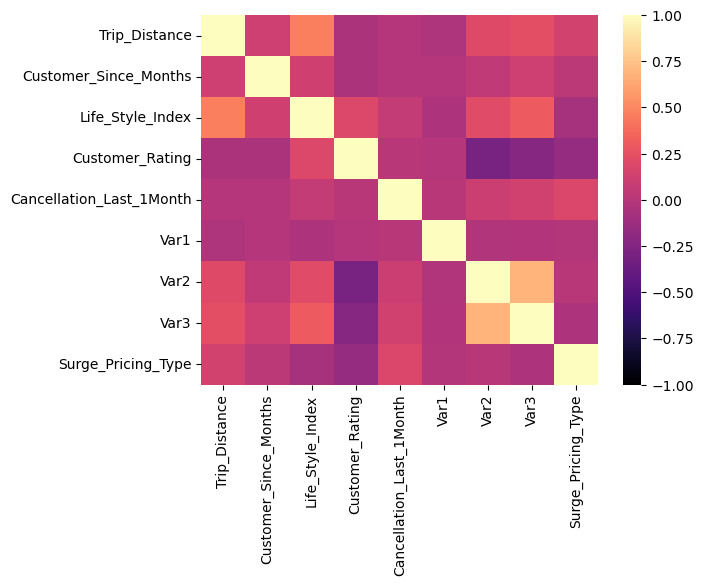

In [13]:
sns.heatmap(data=corr_matrix,
            xticklabels=numeric_cols,
            yticklabels=numeric_cols,
            cmap='magma',
            vmin=-1,
            vmax=1)

plt.show()

In [14]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

get_top_abs_correlations(df[numeric_cols])

Var2              Var3                0.683437
Trip_Distance     Life_Style_Index    0.468332
Life_Style_Index  Var3                0.303324
Customer_Rating   Var2                0.302968
Trip_Distance     Var3                0.231706
dtype: float64

### Training

In [15]:
np.random.seed(2022)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [16]:
X = df.drop('Surge_Pricing_Type', axis=1)
y = df['Surge_Pricing_Type']

In [17]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

**Задание 1.** Обучите One-vs-Rest Logreg. Не забудьте в шаг добавить стандартизацию данных (через `StandardScaler`) Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg. Здесь и далее округляйте до 3 знака после запятой.

Чтобы отдельно и долго не вычислять метрики, можно воспользоваться `classification_report` из `sklearn.metrics`!

In [18]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

### Your code is here
pipe_one_rest = Pipeline([('Scaler', StandardScaler()),
                          ('one_vs_all', OneVsRestClassifier(LogisticRegression()))])

pipe_one_rest.fit(X_train, y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression()))])

Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()` из предложенных. Для лучшего набора гиперпараметров посчитайте те же самые метрики. Валидировать параметры необходимо по `accuracy`. В этот раз проведем настояющую процедуру Кросс-Валидации! 

Для этого в метод `fit` передадим тренировочную часть наших данных, в параметр `cv` ничего не будем передавать (по дефолту 5-fold Кросс-Валидация будет проведена), а итоговые метрики замерим на тесте!

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pipe_one_rest.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.723     0.542     0.619      5372
           2      0.636     0.834     0.722     11349
           3      0.741     0.571     0.645      9612

    accuracy                          0.679     26333
   macro avg      0.700     0.649     0.662     26333
weighted avg      0.692     0.679     0.673     26333



In [20]:
param_grid = {'one_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
              'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1]}

In [21]:
### Your code is here
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(pipe_one_rest, param_grid,
                      scoring='accuracy')

search.fit(X_train, y_train)


GridSearchCV(estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('one_vs_all',
                                        OneVsRestClassifier(estimator=LogisticRegression()))]),
             param_grid={'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1],
                         'one_vs_all__estimator__penalty': ['l1', 'l2',
                                                            'elasticnet']},
             scoring='accuracy')

In [22]:
search.best_score_

0.6806197879917104

In [23]:
search.best_params_

{'one_vs_all__estimator__C': 0.001, 'one_vs_all__estimator__penalty': 'l2'}

In [24]:
pipe_one_rest.set_params(one_vs_all__estimator__C=0.001, one_vs_all__estimator__penalty='l2')

Pipeline(steps=[('Scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression(C=0.001)))])

In [25]:
print(classification_report(y_test, pipe_one_rest.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.723     0.542     0.619      5372
           2      0.636     0.834     0.722     11349
           3      0.741     0.571     0.645      9612

    accuracy                          0.679     26333
   macro avg      0.700     0.649     0.662     26333
weighted avg      0.692     0.679     0.673     26333



In [26]:
pipe_one_rest.classes_

array([1, 2, 3], dtype=int64)

Изобразите три калибровочные кривые для Logistic Classifier: 0-vs-rest, 1-vs-rest, 2-vs-rest. Хорошо ли откалиброван обученный классификатор? 

Заметьте, что `predict_proba` возвращает список из вероятностей для всех наших классов!

In [27]:
pipe_one_rest.predict_proba(X_test)

array([[0.30013462, 0.29224922, 0.40761616],
       [0.01125905, 0.54477435, 0.4439666 ],
       [0.01119501, 0.56535505, 0.42344993],
       ...,
       [0.55494405, 0.06306544, 0.38199051],
       [0.65844735, 0.11620982, 0.22534283],
       [0.12038295, 0.61584146, 0.26377559]])

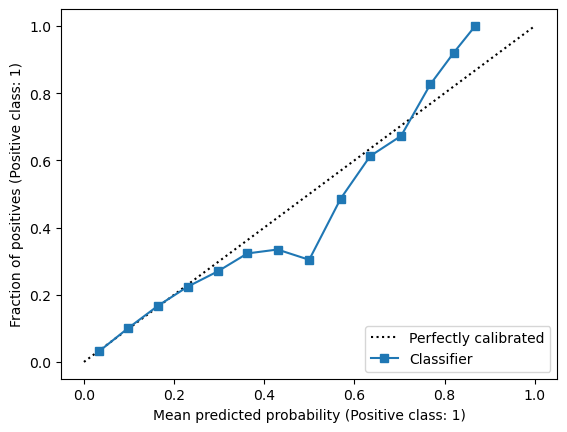

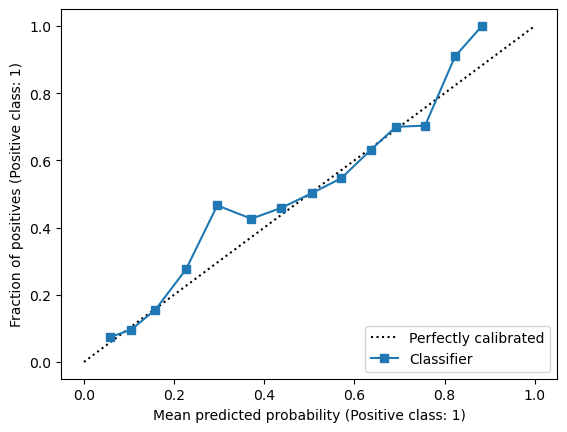

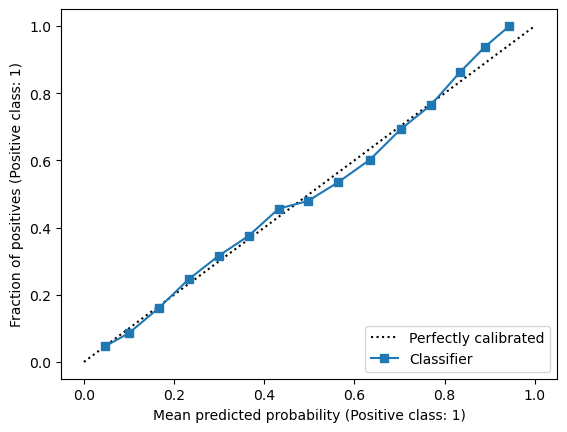

In [28]:
### Your code is here
from sklearn.calibration import CalibrationDisplay
for target_class in range(3):
    CalibrationDisplay.from_predictions(y_test == target_class +1,
                                        pipe_one_rest.predict_proba(X_test)[:, target_class],
                                        n_bins=15)

**Задание 2.** Обучите логистическую регрессию с гиперпараметрами из первого задания на полиномиальных признаках до 4 степени. Сравните метрики с первым заданием.


Пример: Пусть у нас был единственный признак 

$$
d_j = [1, 2, 3, 4]
$$

Тогда полиномиальные признаки до 4 степени от такого будут иметь вид:

$$
d_j^1 = [1, 2, 3, 4]
$$

$$
d_j^2 = [1, 4, 9, 16]
$$

$$
d_j^3 = [1, 8, 27, 64]
$$

$$
d_j^4 = [1, 16, 81, 256]
$$

P.S. Бинарные колонки нет смысла возводить в какие-то степени, поэтому возьмем исключительно вещественные из базовых. 

Для этого можно воспользоваться классическим циклом (или уроком из занятия про `Sberbank Housing Market`). Положите модифицированный датасет в переменную `X_polinomial`!

P.S.S Зачастую еще, создаваю полиномиальные фичи, учитывают "пересечения" признаков, то есть, например, из векторов признаков $d_j, d_i$ генерируют не просто новые степени $d_j^2, d_i^2, d_j^3, d_i^3...$, а еще и признаки вида $d_j \cdot d_i, d_j^2 \cdot d_i, d_j \cdot d_i^2...$, но здесь ограничьтесь просто степенями!

In [29]:
numeric_cols

Index(['Trip_Distance', 'Customer_Since_Months', 'Life_Style_Index',
       'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3',
       'Surge_Pricing_Type'],
      dtype='object')

In [30]:
### Создание полиномиальных признаков

X_polinomial = X.copy()

numeric_cols = numeric_cols.drop('Surge_Pricing_Type')
### Your code is here


for col in numeric_cols:
    for power in [1, 2, 3, 4]:
        polinomial_col = (X_polinomial[col] ** power).to_frame().rename({col:f"{col}_{power}"}, axis=1)
        X_polinomial = pd.concat((X_polinomial, polinomial_col), axis=1)

In [31]:
X_pol_train, X_pol_test, y_train, y_test  = train_test_split(X_polinomial, y, 
                                                             test_size=0.2, 
                                                             shuffle=True, 
                                                             random_state=2022)

In [32]:
### Your code is here
pipe_one_rest.fit(X_pol_train, y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression(C=0.001)))])

По аналогии с первым заданием изобразите три калибровочные кривые. Стало ли лучше?

In [33]:
### Your code is here
print(classification_report(y_test, pipe_one_rest.predict(X_pol_test), digits=3))


              precision    recall  f1-score   support

           1      0.750     0.532     0.623      5372
           2      0.637     0.835     0.722     11349
           3      0.740     0.587     0.655      9612

    accuracy                          0.683     26333
   macro avg      0.709     0.652     0.667     26333
weighted avg      0.697     0.683     0.677     26333



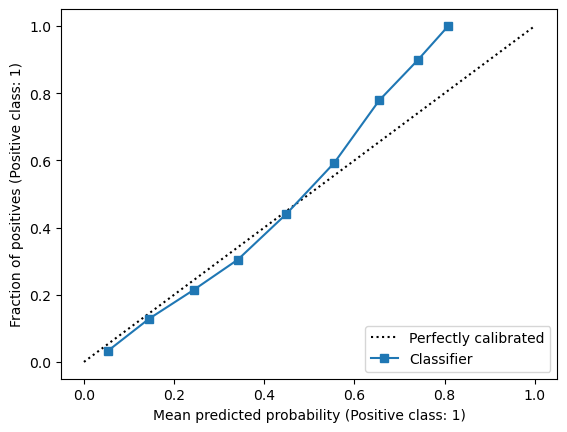

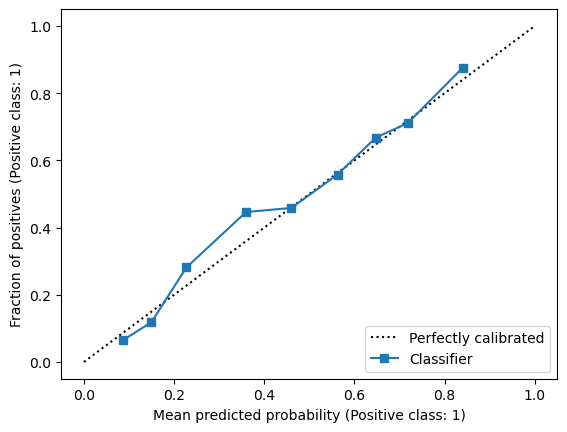

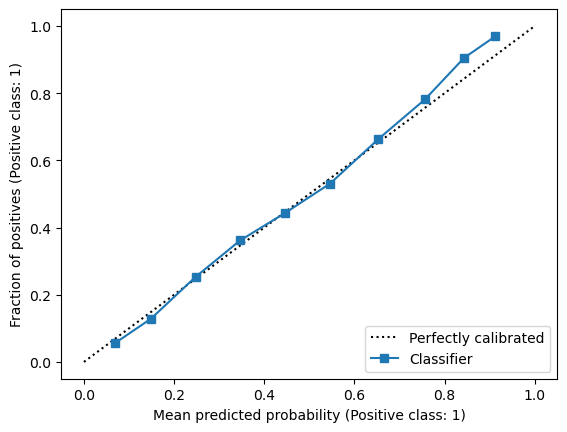

In [34]:
for target_class in range(3):
    CalibrationDisplay.from_predictions(y_test == target_class +1,
                                        pipe_one_rest.predict_proba(X_pol_test)[:, target_class],
                                        n_bins=10)

**Задание 3.** Обучите на датасете без полиномиальных признаков One-vs-One `SGDClassifier` из `sklearn.linear_model`, который использует стохастический градиентный спуск (узнаете о нем позже) и может обучать как `SVM`, так и, например, `LogReg`, если указать в качестве параметра `loss` либо `hinge`, либо `log` соответственно!

Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg.

In [35]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

In [36]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

### Your code is here
pipe_one_one = Pipeline([('Scaler', StandardScaler()),
                         ('one_vs_one', OneVsOneClassifier(SGDClassifier()))])

pipe_one_one.fit(X_train, y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('one_vs_one', OneVsOneClassifier(estimator=SGDClassifier()))])

Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()`. При этом переберите всевозможные функции потерь. Таким образом, при `loss = 'hinge'`, мы обучим SVM, при `loss = 'log'` мы обучим логистическую регрессию и т.д.

Используйте прием с Кросс-Валидацией при подборе параметров, как ранее, а также замерьте метрики на тесте.

In [37]:
param_grid = {'one_vs_one__estimator__loss': ['hinge', 'log', 'modified_huber'],
              'one_vs_one__estimator__penalty': ['l1', 'l2'],
              'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1]}

In [38]:
### Your code is here
search = GridSearchCV(pipe_one_one, param_grid,
                      scoring='accuracy')
search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('one_vs_one',
                                        OneVsOneClassifier(estimator=SGDClassifier()))]),
             param_grid={'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1],
                         'one_vs_one__estimator__loss': ['hinge', 'log',
                                                         'modified_huber'],
                         'one_vs_one__estimator__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [39]:
search.best_params_

{'one_vs_one__estimator__alpha': 0.1,
 'one_vs_one__estimator__loss': 'hinge',
 'one_vs_one__estimator__penalty': 'l2'}

In [40]:
search.best_score_

0.6807052341843631

In [41]:
print(classification_report(y_test, search.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.756     0.517     0.615      5372
           2      0.625     0.876     0.730     11349
           3      0.762     0.535     0.628      9612

    accuracy                          0.678     26333
   macro avg      0.714     0.643     0.658     26333
weighted avg      0.702     0.678     0.669     26333



Можно ли однозначно сказать, какой подход оказался лучше: One-vs-Rest или One-vs-One?